# <center>Geometric Methods in Machine Learning<br/><br/>Poincaré Embeddings<br/><br/>Zakarya Ali et Samir Tanfous</center>

Nous étudions l'article [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/pdf/1705.08039.pdf) de Maximilian Nickel et Douwe Kiela.

## Prérequis
On fait l'import du code et des données nécessaires

In [14]:
import os
import numpy as np
import csv
import random
import time
import pickle
import logger

In [15]:
wordnet_mammal_file = 'data/wordnet_mammal_hypernyms.tsv'

In [48]:
def load_wordnet(wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [49]:
network = load_wordnet(wordnet_mammal_file)
# network

In [50]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [51]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [52]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [53]:
def update(emb, error_):
    """Equation d'update (equation 5)"""
    update =  lr*pow((1 - np.linalg.norm(emb)), 2)*error_/4
    emb = emb - update
    if (np.dot(emb, emb) >= 1):
        emb = emb/np.sqrt(np.dot(emb, emb)) - EPSILON
    return emb

In [54]:
def get_negative_candidates(network, vocab, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    while (len(negs) < num_negs):
            neg = random.choice(vocab)
            if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
                negs.append(neg)
    return negs

# 1. Entrainement

In [55]:
#Initialisation des variables

# embedding of nodes of network
emb = {}
embedding_size = 2 #Dimensionality of the trained vectors

#epochs
num_epochs = 50

#num_negs
num_negs = 20

#learning rate
lr = 0.01

EPSILON = 0.00001 # to avoid overflow while dividing

In [56]:
# Randomly uniform distribution
for a in network:
    for b in network[a]:
        emb[b] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))
    emb[a] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))

vocab = list(emb.keys())
random.shuffle(vocab)

In [57]:
# the leave nodes are not connected to anything
for a in emb:
    if not a in network:
        network[a] = []
        
# The plot of initialized embeddings
# plotall("init")

In [58]:
last_time = time.time()
for epoch in range(num_epochs):
    for u in vocab:
#         print(u)
        if not network[u]: # une node
            continue
        v = random.choice(network[u]) # u et v sont liés
        gamma_u_v = compute_gamma(emb[u], emb[v])
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
        
        negs = [] # pairs of not related nodes, the first node in the pair is `pos1`
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, u, num_negs) 
#         print('negs :', negs)  
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-1*dist_neg)
        loss = -1*dist_p_u_v - np.log(loss_den)
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_p = -1
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = der_p * deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = der_p * deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        emb[u] = update(emb[u], -1*der_p_u)
        emb[v] = update(emb[v], -1*der_p_v)
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            emb[u] = update(emb[u], -1*der_neg[0])
            emb[neg] = update(emb[neg], -1*der_neg[1])
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    last_time = time.time()
pickle.dump(emb, open('data/train.pickle', 'wb'))

Epoch #1, temps d'exécution: 1.52 seconds
Epoch #2, temps d'exécution: 1.55 seconds
Epoch #3, temps d'exécution: 1.57 seconds
Epoch #4, temps d'exécution: 1.55 seconds
Epoch #5, temps d'exécution: 1.55 seconds
Epoch #6, temps d'exécution: 1.56 seconds
Epoch #7, temps d'exécution: 1.57 seconds
Epoch #8, temps d'exécution: 1.56 seconds
Epoch #9, temps d'exécution: 1.56 seconds
Epoch #10, temps d'exécution: 1.56 seconds
Epoch #11, temps d'exécution: 1.56 seconds
Epoch #12, temps d'exécution: 1.55 seconds
Epoch #13, temps d'exécution: 1.56 seconds
Epoch #14, temps d'exécution: 1.56 seconds
Epoch #15, temps d'exécution: 1.55 seconds
Epoch #16, temps d'exécution: 1.56 seconds
Epoch #17, temps d'exécution: 1.57 seconds
Epoch #18, temps d'exécution: 1.56 seconds
Epoch #19, temps d'exécution: 1.56 seconds
Epoch #20, temps d'exécution: 1.56 seconds
Epoch #21, temps d'exécution: 1.57 seconds
Epoch #22, temps d'exécution: 1.55 seconds
Epoch #23, temps d'exécution: 1.56 seconds
Epoch #24, temps d'e

# 2. Résultats

In [60]:
import matplotlib.pyplot as plt
% matplotlib inline

In [61]:
emb

{'marsupial.n.01': array([-0.00262547, -0.01552378]),
 'mammal.n.01': array([-0.00078389,  0.00017787]),
 'metatherian.n.01': array([-0.00348614, -0.01398102]),
 'kangaroo.n.01': array([-0.00560375, -0.01770221]),
 'even-toed_ungulate.n.01': array([  2.53908799e-03,  -1.47493009e-05]),
 'ruminant.n.01': array([ 0.00331716, -0.00028657]),
 'goat.n.01': array([ 0.01121226,  0.00316391]),
 'placental.n.01': array([-0.00337567,  0.00121184]),
 'bovid.n.01': array([ 0.00395338, -0.00161826]),
 'ungulate.n.01': array([-0.00017023, -0.00228065]),
 'domestic_goat.n.01': array([ 0.01878926,  0.00842692]),
 'ground_squirrel.n.02': array([ 0.00278042,  0.00327343]),
 'squirrel.n.01': array([ 0.00137188,  0.00096384]),
 'rodent.n.01': array([ 0.00161723,  0.00169018]),
 'rock_squirrel.n.01': array([ 0.01587129,  0.00760922]),
 'dog.n.01': array([ 0.00281081,  0.00829308]),
 'sporting_dog.n.01': array([-0.00085786,  0.00766726]),
 'carnivore.n.01': array([ 0.00058429,  0.00282598]),
 'canine.n.02':

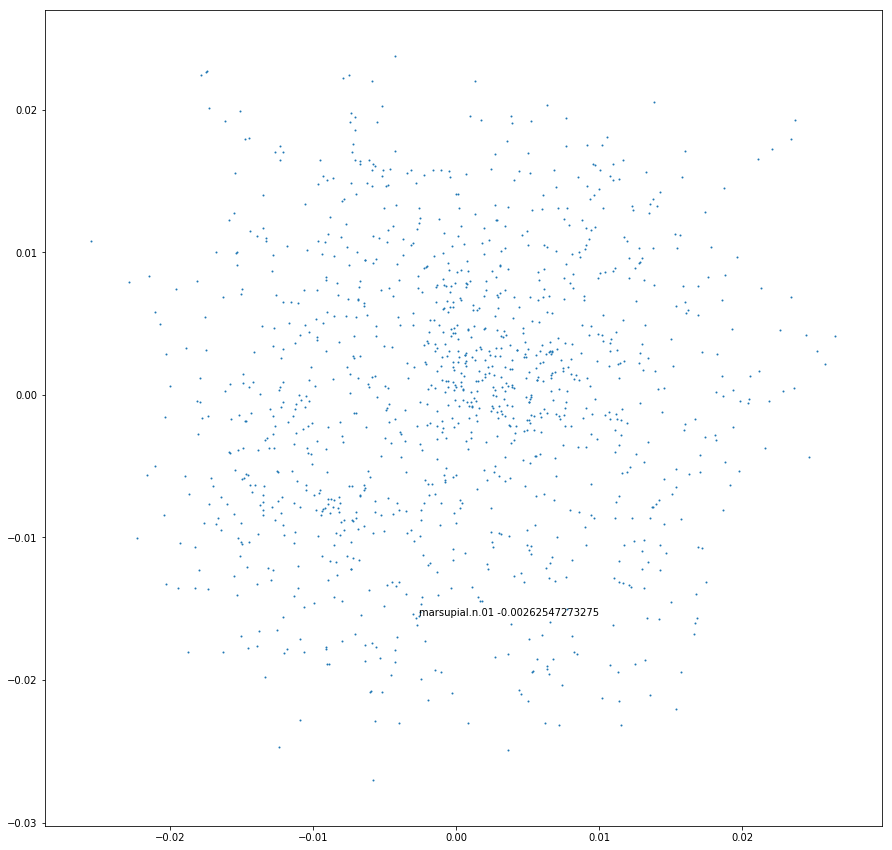

In [99]:
fig=plt.figure(figsize=(15,15))
names = []
positions_x = []
positions_y = []
for key in emb:
    names.append(key)
    positions_x.append(emb[key][0])
    positions_y.append(emb[key][1])

plt.scatter(positions_x,positions_y, s=1)
k=0
plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

# circle = plt.Circle((0, 0), 1, color='g',fill=False)

# plt.axis([-1,1,-1,1])
# ax=fig.add_subplot(1,1,1)
# ax.add_patch(circle)

plt.show()